In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- New code cell: Summarize folder contents ---

import os
from datetime import datetime
from PIL import Image  # For image file dimension extraction

# Base directory you want to scan
base_path = "data/MESA"

# Dictionary to store the summary for each folder
folder_summary = {}

for root, dirs, files in os.walk(base_path):
    # Initialize summary for the current folder
    folder_summary[root] = {
        "file_extensions": {},  # Will store files organized by file extension
        "files": []             # List of file info dictionaries
    }
    
    for file in files:
        file_path = os.path.join(root, file)
        file_ext = os.path.splitext(file)[1].lower() if os.path.splitext(file)[1] else "none"
        stat_info = os.stat(file_path)
        
        # Basic file attributes
        file_info = {
            "file_name": file,
            "extension": file_ext,
            "path": file_path,
            "size_bytes": stat_info.st_size,
            "last_modified": datetime.fromtimestamp(stat_info.st_mtime).isoformat()
        }
        
        # Additional attributes based on file type:
        # For CSV files, we try to get a preview of rows and columns.
        if file_ext == ".csv":
            try:
                df = pd.read_csv(file_path, nrows=5)  # read a sample of rows
                file_info["preview_rows"] = df.shape[0]
                file_info["preview_columns"] = list(df.columns)
            except Exception as e:
                file_info["preview_error"] = str(e)
        
        # For image files, we try to get the dimensions (width, height).
        elif file_ext in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
            try:
                img = Image.open(file_path)
                file_info["image_size"] = img.size   # (width, height)
            except Exception as e:
                file_info["image_error"] = str(e)
        
        # Append this file info to the folder's list
        folder_summary[root]["files"].append(file_info)
        
        # Organize file info by extension within the current folder:
        if file_ext not in folder_summary[root]["file_extensions"]:
            folder_summary[root]["file_extensions"][file_ext] = {
                "file_count": 0,
                "files": []
            }
        folder_summary[root]["file_extensions"][file_ext]["file_count"] += 1
        folder_summary[root]["file_extensions"][file_ext]["files"].append(file_info)

# Global summary: Count how many files exist for each extension across all folders.
global_extensions_summary = {}
for folder in folder_summary:
    for ext, data in folder_summary[folder]["file_extensions"].items():
        if ext not in global_extensions_summary:
            global_extensions_summary[ext] = 0
        global_extensions_summary[ext] += data["file_count"]

# Display the results
print("Summary of folders:")
for folder, summary in folder_summary.items():
    print(f"\nFolder: {folder}")
    print(f"Total files: {len(summary['files'])}")
    print("File types breakdown:", {ext: stats["file_count"] for ext, stats in summary["file_extensions"].items()})

print("\nGlobal file extension count:", global_extensions_summary)

Summary of folders:

Global file extension count: {}


In [2]:
# --- New code cell: Inspect first 10 EDF files ---

import os
import pyedflib  # make sure to install pyedflib with: pip install pyedflib

# Assuming 'base_path' is defined from the previous code cell, e.g.,
# base_path = "/Users/tereza/mesa"

# List to collect the first 10 EDF file paths from the base directory and its subfolders
edf_path_list = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(".edf"):
            edf_path_list.append(os.path.join(root, file))
            if len(edf_path_list) >= 10:
                break
    if len(edf_path_list) >= 10:
        break

# List to store attributes for each EDF file
edf_attributes = []

for file_path in edf_path_list:
    try:
        reader = pyedflib.EdfReader(file_path)
        
        # Extract file header information
        header = reader.getHeader()
        
        # Extract per-channel (signal) details:
        signals = []
        for i in range(reader.signals_in_file):
            signal_info = {
                "label": reader.getLabel(i),
                "sample_frequency": reader.getSampleFrequency(i),
                "physical_min": reader.getPhysicalMinimum(i),
                "physical_max": reader.getPhysicalMaximum(i)
            }
            signals.append(signal_info)
        
        # Store all attributes in a dictionary
        edf_info = {
            "file_path": file_path,
            "header": header,
            "n_signals": reader.signals_in_file,
            "signals": signals
        }
        edf_attributes.append(edf_info)
        reader.close()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Display the extracted attributes for each EDF file
for info in edf_attributes:
    print(f"\nAttributes for EDF file: {info['file_path']}")
    print("Header:")
    for key, val in info["header"].items():
        print(f"  {key}: {val}")
    print("Signals:")
    for sig in info["signals"]:
        print(f"  {sig}")
    print("-" * 40)


Attributes for EDF file: /Users/tereza/mesa/polysomnography/edfs/mesa-sleep-1912.edf
Header:
  technician: 
  recording_additional: 
  patientname: 
  patient_additional: 
  patientcode: 
  equipment: 
  admincode: 
  sex: 
  startdate: 1985-01-01 21:59:59
  birthdate: 
  gender: 
Signals:
  {'label': 'EKG', 'sample_frequency': 256.0, 'physical_min': -5.0, 'physical_max': 5.0}
  {'label': 'EOG-L', 'sample_frequency': 256.0, 'physical_min': -2.0, 'physical_max': 2.0}
  {'label': 'EOG-R', 'sample_frequency': 256.0, 'physical_min': -2.0, 'physical_max': 2.0}
  {'label': 'EMG', 'sample_frequency': 256.0, 'physical_min': -2.0, 'physical_max': 2.0}
  {'label': 'EEG1', 'sample_frequency': 256.0, 'physical_min': -2.0, 'physical_max': 2.0}
  {'label': 'EEG2', 'sample_frequency': 256.0, 'physical_min': -2.0, 'physical_max': 2.0}
  {'label': 'EEG3', 'sample_frequency': 256.0, 'physical_min': -5.0, 'physical_max': 5.0}
  {'label': 'Pres', 'sample_frequency': 32.0, 'physical_min': -30.0, 'physical

Loading EDF file: /Users/tereza/mesa/polysomnography/edfs/mesa-sleep-1912.edf


/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_85247/73194525.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


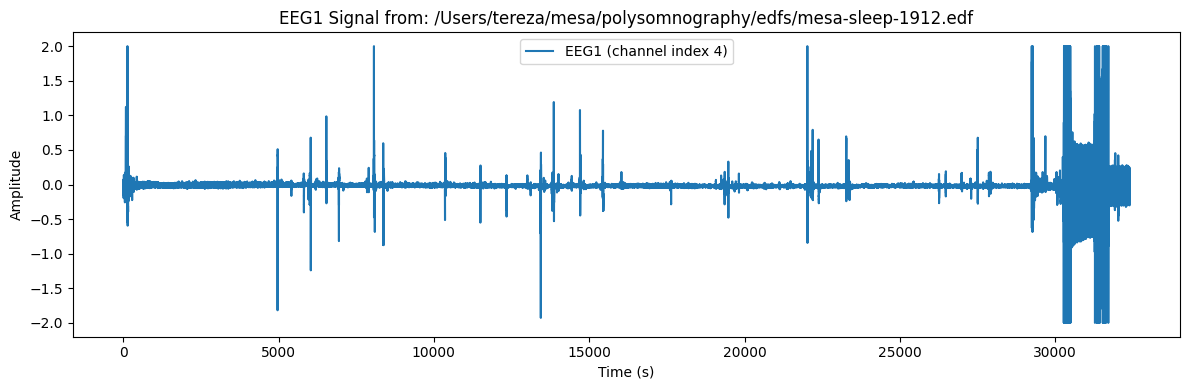

In [3]:
# --- New code cell: Plot the EEG1 signal for the first subject ---

import os
import pyedflib
import matplotlib.pyplot as plt
import numpy as np

# Ensure edf_path_list is available from the previous cell; otherwise, rebuild it.
if 'edf_path_list' not in globals():
    base_path = "/Users/tereza/mesa"
    edf_path_list = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".edf"):
                edf_path_list.append(os.path.join(root, file))
                if len(edf_path_list) >= 10:
                    break
        if len(edf_path_list) >= 10:
            break

if len(edf_path_list) == 0:
    print("No EDF files found in the specified directory.")
else:
    edf_file = edf_path_list[0]  # use the first EDF file for the first subject
    print("Loading EDF file:", edf_file)
    try:
        reader = pyedflib.EdfReader(edf_file)
        n_channels = reader.signals_in_file
        
        # Attempt to find the channel labeled "EEG1"
        found_channel_index = None
        for i in range(n_channels):
            label = reader.getLabel(i).strip().upper()  # standardize label for comparison
            if label == "EEG1":
                found_channel_index = i
                break
        
        if found_channel_index is None:
            print("EEG1 channel not found in the file.")
        else:
            # Read the signal data and get the sample frequency
            signal = reader.readSignal(found_channel_index)
            sfreq = reader.getSampleFrequency(found_channel_index)
            t = np.arange(len(signal)) / sfreq  # time axis in seconds
            
            # Plot the signal
            plt.figure(figsize=(12, 4))
            plt.plot(t, signal, label=f"EEG1 (channel index {found_channel_index})")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.title(f"EEG1 Signal from: {edf_file}")
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        reader.close()
    except Exception as e:
        print("Error loading or plotting EDF file:", e)

Loading EDF file: /Users/tereza/mesa/polysomnography/edfs/mesa-sleep-1912.edf
EEG1 Channel Details:
 Number of samples: 8294144
 Sample Frequency: 256.00 Hz
 Total Duration: 32399.00 seconds
 Signal Statistics: Min=-2.00, Max=2.00, Mean=-0.02


/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_85247/253432434.py:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


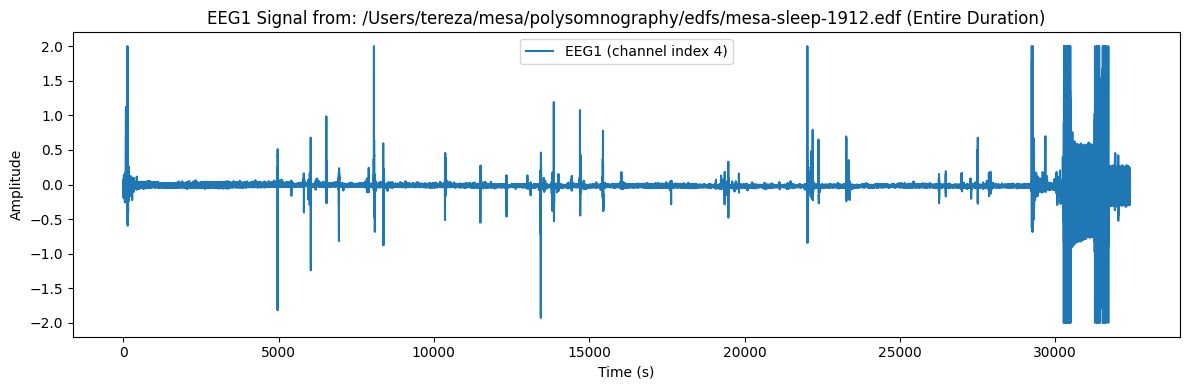

In [4]:
# --- New code cell: Plot the EEG1 signal with detailed info for the first subject ---

import os
import pyedflib
import matplotlib.pyplot as plt
import numpy as np

# Ensure edf_path_list is available from a previous cell; if not, rebuild it.
if 'edf_path_list' not in globals():
    base_path = "/Users/tereza/mesa"
    edf_path_list = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".edf"):
                edf_path_list.append(os.path.join(root, file))
                if len(edf_path_list) >= 10:
                    break
        if len(edf_path_list) >= 10:
            break

if len(edf_path_list) == 0:
    print("No EDF files found in the specified directory.")
else:
    edf_file = edf_path_list[0]  # Use the first EDF file for the first subject.
    print("Loading EDF file:", edf_file)
    try:
        reader = pyedflib.EdfReader(edf_file)
        n_channels = reader.signals_in_file
        
        # Attempt to find the channel labeled "EEG1"
        found_channel_index = None
        for i in range(n_channels):
            label = reader.getLabel(i).strip().upper()  # Standardize label for comparison.
            if label == "EEG1":
                found_channel_index = i
                break
        
        if found_channel_index is None:
            print("EEG1 channel not found in the file.")
        else:
            # Read the signal data and get the sample frequency.
            signal = reader.readSignal(found_channel_index)
            sfreq = reader.getSampleFrequency(found_channel_index)
            n_samples = len(signal)
            duration = n_samples / sfreq
            
            # Print detailed channel information.
            print("EEG1 Channel Details:")
            print(" Number of samples:", n_samples)
            print(" Sample Frequency: {:.2f} Hz".format(sfreq))
            print(" Total Duration: {:.2f} seconds".format(duration))
            print(" Signal Statistics: Min={:.2f}, Max={:.2f}, Mean={:.2f}".format(signal.min(), signal.max(), signal.mean()))
            
            # Create a time axis and plot the entire signal.
            t = np.arange(n_samples) / sfreq  # Time axis in seconds.
            plt.figure(figsize=(12, 4))
            plt.plot(t, signal, label=f"EEG1 (channel index {found_channel_index})")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.title(f"EEG1 Signal from: {edf_file} (Entire Duration)")
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        reader.close()
    except Exception as e:
        print("Error loading or plotting EDF file:", e)